# Asymmetric Potentials
For convenience the key equations are given below from https://arxiv.org/pdf/astro-ph/9407016.pdf:

1) Fokker-Planck equation
$$    \frac{\partial P(\varphi,t)}{\partial t} = \frac{1}{3H}\frac{\partial}{\partial \varphi}\left(V'(\varphi) P(\varphi,t)\right) + \frac{H^3}{8\pi^2}\frac{\partial^2 P(\varphi,t)}{\partial \varphi^2} $$

2) Schrodinger-like equation
$$     -\frac{1}{2}\frac{\partial^2 \Phi_n(\varphi)}{\partial \varphi^2} + W(\varphi) \Phi_n (\varphi) = \frac{4\pi^2\Lambda_n}{H^3}\Phi_n(\varphi) $$

3) Effective potential
$$ W(\varphi) = \frac{1}{2}\left[v'(\varphi)^2-v''(\varphi)\right], \> \> v(\varphi) = \frac{4\pi^2}{3H^4} V(\varphi) $$

4) Solutions take the form
$$ P(\varphi,t) = \exp\left(-\frac{4\pi^2 V(\varphi)}{3H^4}\right) \sum^{\infty}_{n=0} a_n \Phi_n (\varphi) e^{-\Lambda_n (t-t_0)} $$

In [1]:
import numpy as np
from math import factorial
from scipy import optimize
from scipy.integrate import odeint, simps
from scipy.special import eval_hermite
import matplotlib.pyplot as plt
%matplotlib inline

Here we know consider a potential of the form
$$V(\varphi) = \mu^3 \varphi + \frac{1}{2}m^2\varphi^2 + \frac{1}{4}\lambda \varphi^4. $$
Following https://arxiv.org/pdf/2001.04494.pdf, the Schrodinger-like equation can be expressed in terms of dimensionless quantities:
$$ \bar{\alpha} \equiv \frac{-m^2}{\sqrt{\lambda}H^2}, \> \> \beta = \frac{\mu^3}{\lambda^{1/4}H^3}.  $$
We also have
$$ z \equiv \frac{\lambda^{1/4}\Omega}{H}\varphi, \>\> \Omega \equiv 1 + \sqrt{\bar{\alpha}}+\beta. $$
With the above parameters the Schrödinger-like equation takes the form 
$$\frac{\partial \Phi_n(z)}{\partial z} \equiv Y, $$
$$\frac{\partial Y}{\partial z} = \left(4\pi^2\frac{\bar{\alpha}+\frac{4\pi^2}{3}\beta^2}{3\Omega^2}-\frac{32\pi^4\bar{\alpha}\beta z}{9\Omega^3}-4\pi^2\frac{1-\frac{4\pi^2}{9}\bar{\alpha}^2}{\Omega^4}z^2+\frac{32\pi^4\beta z^3}{9\Omega^5}-\frac{32\pi^4\bar{\alpha} z^4}{9\Omega^6} + \frac{16\pi^4 z^6}{9\Omega^8}-\frac{8\pi^2(1+\bar{\alpha}+\beta^2)\tilde{\Lambda}_n}{\Omega^2}\right)\Phi_n(z).  $$
Eigenvalues are rescaled as 
$$\tilde{\Lambda}_n(\alpha) = \frac{\Lambda_n}{\lambda^{1/2}H(1+\bar{\alpha}+\beta^2)}. $$
For now let us set $\bar{\alpha}=1$, $\beta=0$

In [2]:
# Setting parameters
alpha_bar = 1
beta = 0
omega = 1 + np.sqrt(alpha_bar) + beta

## WKB approximation
$$ Q(z) = 4\pi^2\frac{\bar{\alpha}+\frac{4\pi^2}{3}\beta^2}{3\Omega^2}-\frac{32\pi^4\bar{\alpha}\beta z}{9\Omega^3}-4\pi^2\frac{1-\frac{4\pi^2}{9}\bar{\alpha}^2}{\Omega^4}z^2+\frac{32\pi^4\beta z^3}{9\Omega^5}-\frac{32\pi^4\bar{\alpha} z^4}{9\Omega^6} + \frac{16\pi^4 z^6}{9\Omega^8}-\frac{8\pi^2(1+\bar{\alpha}+\beta^2)\tilde{\Lambda}_n}{\Omega^2}, $$
$$ Q'(z) = -\frac{32\pi^4\bar{\alpha}\beta}{9\Omega^3}-8\pi^2\frac{1-\frac{4\pi^2}{9}\bar{\alpha}^2}{\Omega^4}z+\frac{32\pi^4\beta z^2}{3\Omega^5}-\frac{128\pi^4\bar{\alpha} z^3}{9\Omega^6} + \frac{32\pi^4 z^5}{3\Omega^8}, $$
$$ Q''(z) = -8\pi^2\frac{1-\frac{4\pi^2}{9}\bar{\alpha}^2}{\Omega^4}+\frac{64\pi^4\beta z}{3\Omega^5}-\frac{128\pi^4\bar{\alpha} z^2}{3\Omega^6} + \frac{160\pi^4 z^4}{3\Omega^8}. $$


$$S_0(z) = \pm \int^z_{z_0}\sqrt{Q(x)} dx, $$
$$S_1(z) = -\frac{1}{4}\left[\text{ln}Q(x)\right]^z_{z_0}, $$
$$S_2(z) = -\frac{1}{4}\frac{Q'(z)}{Q(z)^2} - \frac{1}{8}\int^z_{z_0} \frac{Q''(x)}{Q(x)^3}dx.$$
The solution then takes the form 
$$\Phi_n(z) \simeq \frac{c_1}{Q(z)^{1/4}}\text{exp}\left[\int^z_{z_0} \sqrt{Q(x)}dx -\frac{1}{4}\frac{Q'(z)}{Q(z)^2} - \frac{1}{8}\int^z_{z_0} \frac{Q''(x)}{Q(x)^3}dx\right] + \frac{c_2}{Q(z)^{1/4}}\text{exp}\left[-\int^z_{z_0} \sqrt{Q(x)}dx +\frac{1}{4}\frac{Q'(z)}{Q(z)^2} + \frac{1}{8}\int^z_{z_0} \frac{Q''(x)}{Q(x)^3}dx\right] $$
Ignoring second-order terms the derivative is:
$$\Phi'_n(z) \simeq \frac{Q'(z)}{4Q(z)^{5/4}}\left(c_1\text{exp}\left[\int^z_{z_0} \sqrt{Q(x)}dx \right] + c_2\text{exp}\left[-\int^z_{z_0} \sqrt{Q(x)}dx \right]\right) + Q(z)^{1/4}\left(c_1\text{exp}\left[\int^z_{z_0} \sqrt{Q(x)}dx \right] - c_2\text{exp}\left[-\int^z_{z_0} \sqrt{Q(x)}dx \right]\right) $$

In [3]:
# Eigenvalue
eigenvalue = 0

# Function for Q defined above
def Q_function(z):
    '''Evaluates Q(z) defined above
    z: array of values for which Q(z) is to be evaluated'''
    
    # Break up calculation into multiple parts
    x_1 = ((alpha_bar + ((4*np.pi**2)/3)*beta**2)/(3*omega**2))*4*np.pi**2 
    x_2 = - ((32*np.pi**4)*alpha_bar*beta*z)/(9*omega**3)
    x_3 = - (4*np.pi**2)*((1 - (4*(np.pi*alpha_bar)**2)/9)/(omega**4))*z**2
    x_4 = ((32*np.pi**4)*beta*z**3)/(9*omega**5) - ((32*np.pi**4)*alpha_bar*z**4)/(9*omega**6)
    x_5 = ((16*np.pi**4)*z**6)/(9*omega**8) - ((1 + alpha_bar + beta**2)*eigenvalue*8*np.pi**2)/(omega**2)
    
    # Computes full function
    Q = x_1 + x_2 + x_3 + x_4 + x_5
    
    return Q

In [4]:
# Function for the gradient defined above
def Q_function_gradient(z):
    '''Evaluates the gradient for Q(z) defined above
    z: array of values for which Q(z) is to be evaluated'''
    
    # Break up calculation into multiple parts
    x_1 = - ((32*np.pi**4)*alpha_bar*beta)/(9*omega**3)
    x_2 = - (8*np.pi**2)*((1 - (4*(np.pi*alpha_bar)**2)/9)/(omega**4))*z
    x_3 = ((32*np.pi**4)*beta*z**2)/(3*omega**5) - ((128*np.pi**4)*alpha_bar*z**3)/(9*omega**6)
    x_4 = ((32*np.pi**4)*z**5)/(3*omega**8) 
    
    # Computes full function
    Q_gradient = x_1 + x_2 + x_3 + x_4
    
    return Q_gradient

def Q_second_derivative(z):
    '''Evaluates the second derivative for Q(z) defined above
    z: array of values for which Q(z) is to be evaluated'''
    
    # Break up calculation into multiple parts
    x_1 = - (8*np.pi**2)*((1 - (4*(np.pi*alpha_bar)**2)/9)/(omega**4))
    x_2 = ((64*np.pi**4)*beta*z)/(3*omega**5) - ((128*np.pi**4)*alpha_bar*z**2)/(3*omega**6)
    x_3 = ((160*np.pi**4)*z**4)/(3*omega**8) 
    
    # Computes full function
    Q_second_derivative = x_1 + x_2 + x_3
    
    return Q_second_derivative

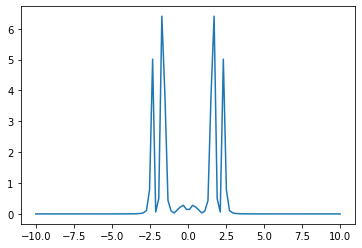

In [5]:
# Plotting ratio of gradient of Q with Q^2
z = np.linspace(-10, 10, 100)
Q = Q_function(z)
Q_gradient = Q_function_gradient(z)
plt.plot(z, abs(Q_gradient/(Q**2)))

(0, 1)

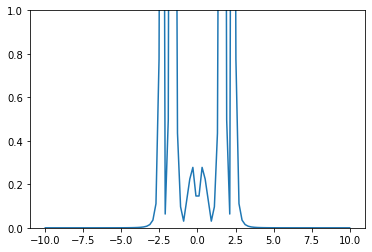

In [6]:
# Plotting ratio of gradient of Q with Q^2
z = np.linspace(-10, 10, 100)
Q = Q_function(z)
Q_gradient = Q_function_gradient(z)
plt.plot(z, abs(Q_gradient/(Q**2)))
plt.ylim(0, 1)

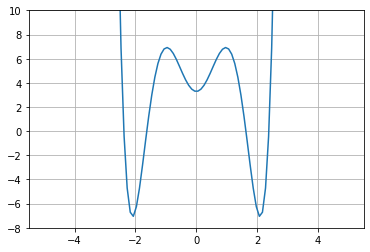

In [7]:
# Plot Q(z), points where Q(z) = 0 are analogous to classical turning points in quantum mechanics
z = np.linspace(-5, 5, 100)
Q = Q_function(z)
plt.plot(z, Q)
plt.ylim(-8, 10)
plt.grid()

In [8]:
class eigenfunction_finder_WKB:
    '''Class for finding the eigenfunction for a the rescaled parameters z and alpha'''
    def __init__(self):
        '''Initialises the range of rescaled field values for which the field is
        to be integrated'''
        
        # Parameters
        self.alpha_bar = 1
        self.beta = 0
        self.omega = 1 + np.sqrt(self.alpha_bar) + self.beta 
        self.eigenvalue = 0
 
    def Q_function(self, z):
        '''Evaluates Q(z) defined above
        z: array of values for which Q(z) is to be evaluated'''
    
        # Break up calculation into multiple parts
        x_1 = ((self.alpha_bar + ((4*np.pi**2)/3)*self.beta**2)/(3*self.omega**2))*4*np.pi**2 
        x_2 = - ((32*np.pi**4)*self.alpha_bar*self.beta*z)/(9*self.omega**3)
        x_3 = - (4*np.pi**2)*((1 - (4*(np.pi*self.alpha_bar)**2)/9)/(self.omega**4))*z**2
        x_4 = ((32*np.pi**4)*self.beta*z**3)/(9*self.omega**5) - ((32*np.pi**4)*self.alpha_bar*z**4)/(9*self.omega**6)
        x_5 = ((16*np.pi**4)*z**6)/(9*self.omega**8) - ((1 + self.alpha_bar + self.beta**2)*self.eigenvalue*8*np.pi**2)/(self.omega**2)
    
        # Computes full function
        Q = x_1 + x_2 + x_3 + x_4 + x_5
    
        return Q

    def Q_function_gradient(self, z):
        '''Evaluates the gradient for Q(z) defined above
        z: array of values for which Q(z) is to be evaluated'''
    
        # Break up calculation into multiple parts
        x_1 = - ((32*np.pi**4)*self.alpha_bar*self.beta)/(9*self.omega**3)
        x_2 = - (8*np.pi**2)*((1 - (4*(np.pi*self.alpha_bar)**2)/9)/(self.omega**4))*z
        x_3 = ((32*np.pi**4)*self.beta*z**2)/(3*self.omega**5) - ((128*np.pi**4)*self.alpha_bar*z**3)/(9*self.omega**6)
        x_4 = ((32*np.pi**4)*z**5)/(3*self.omega**8) 
    
        # Computes full function
        Q_gradient = x_1 + x_2 + x_3 + x_4
    
        return Q_gradient

    def WKB_function(self, WKB_lower_limit, WKB_upper_limit):
        '''Evaluates WKB approximation of eigenfunction to second-order
        upper_limit: upper integration limit
        lower_limit: lower integration limit'''
    
        # Creates array of z values
        z = np.linspace(WKB_lower_limit, WKB_upper_limit, 5000)
        dz = z[1] - z[0]
    
        # Q and its derivatives
        Q = self.Q_function(z)
        Q_gradient = self.Q_function_gradient(z)
        #Q_derivative_second = Q_second_derivative(z)
    
    
        # Integration for S_0 and S_1
        S_0 = simps(np.sqrt(Q), z, dz)
        #S_2[i] = -0.25*(Q_gradient[i + 1]/(Q[i + 1]**2)) - 0.125*simps(Q_derivative_second[:i + 2]/(Q[:i+2]**3), z[:i + 2], dz)
    
        # Computes WKB wavefunction
        WKB_phi = np.exp(-S_0)/(Q[0]**0.25)
        WKB_gradient = (Q_gradient[0]/(Q[0]**1.25) - Q[0]**0.25)*np.exp(-S_0)
    
        # Obtains the initial conditions from the WKB approximation
        WKB_initial_conditions = [WKB_phi, WKB_gradient]
        self.V = WKB_initial_conditions
        
        # Sets integration range starting from where we left of the WKB approximation
        self.z = np.linspace(WKB_lower_limit, -WKB_lower_limit, 3000)
    
        return WKB_initial_conditions
    
    def schrodinger_like_ODE(self, V, z):
        '''Computes the derivatives of the Schrodinger-like equation'''
        
        # Empty array for derivatives
        dV = np.zeros(2)
        
        # Evaluates Q
        Q = self.Q_function(z)
        
        # Computes derivatives
        dV[0] = V[1]
        dV[1] = V[0]*Q
        return dV    

    def eigenfunction(self, eigenvalue):
        '''Integrates the eigenfunction for the field based on the given
        field range and returns the projected solution based on the
        eigenvalue'''
        
        self.eigenvalue = eigenvalue

        # Initial guess range for classical turning point 
        WKB_upper = -9
        WKB_lower = -10
        Q_upper = self.Q_function(WKB_upper)
        Q_lower = self.Q_function(WKB_lower)
        # Ensures sign change in interval
        while Q_upper/Q_lower > 0:
            # Extends guess interval
            WKB_upper += 0.2
            Q_upper = self.Q_function(WKB_upper)
        
        # Computes the turning point
        turning_point = optimize.brentq(self.Q_function, WKB_lower, WKB_upper, xtol=tolerance)
        
        # WKB integration range
        WKB_upper = turning_point - 0.1
        WKB_lower = WKB_upper - 1
        
        # Generates WKB initial conditions
        self.WKB_function(WKB_lower, WKB_upper)
        
        # Integrates to find eigenfunction
        V = odeint(self.schrodinger_like_ODE, self.V, self.z)
        
        return V[-1,0]
    
    def eigenfunction_full(self, eigenvalue):
        '''Integrates the eigenfunction for the field based on the given
        field range and returns the projected solution based on the
        eigenvalue'''
        
        self.eigenvalue = eigenvalue
        
        # Integrates to find eigenfunction
        V = odeint(self.schrodinger_like_ODE, self.V, self.z)

        return V[:,0]

In [9]:
# Integration range for WKB approximation
WKB_lower_limit = -3.25
WKB_upper_limit = -2.38124

# Applies WKB approximation to find initial conditions and integrates numerically
WKB_solution = eigenfunction_finder_WKB()
WKB_solution.WKB_function(WKB_lower_limit, WKB_upper_limit)
WKB_phi = WKB_solution.eigenfunction_full(0)
z = WKB_solution.z

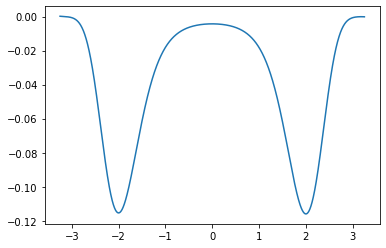

In [10]:
# Plotting
plt.plot(z, WKB_phi)

In [11]:
# Integration range for WKB approximation
WKB_lower_limit = -3.7
WKB_upper_limit = -2.7

# Applies WKB approximation to find initial conditions and integrates numerically
WKB_solution = eigenfunction_finder_WKB()
WKB_solution.beta = 0.5
print(WKB_solution.Q_function(-2.6858235))
WKB_solution.WKB_function(WKB_lower_limit, WKB_upper_limit)
WKB_phi = WKB_solution.eigenfunction_full(0)
z = WKB_solution.z

2.751121019173297e-05


(-0.5, 0.5)

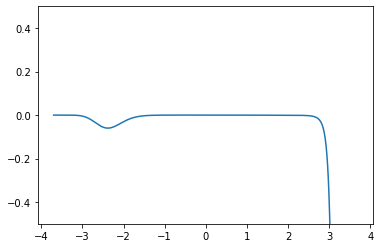

In [12]:
# Plotting
plt.plot(z, WKB_phi)
plt.ylim(-0.5, 0.5)

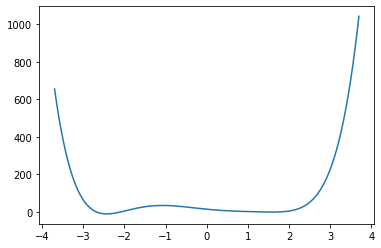

In [13]:
plt.plot(z, WKB_solution.Q_function(z))

In [14]:
# Tolerance on eigenvalue
tolerance = 1e-6

# Eigenvalue guess range
upper_eigenvalue = 0.2
lower_eigenvalue = 0.01

# Applies WKB approximation to find initial conditions and integrates numerically
WKB_solution = eigenfunction_finder_WKB()
WKB_solution.beta = 0.5
scipy_brent_1, results_brent_1 = optimize.brentq(WKB_solution.eigenfunction, lower_eigenvalue, upper_eigenvalue, full_output=True, xtol=tolerance)
WKB_1 = WKB_solution.eigenfunction_full(scipy_brent_1)
z = WKB_solution.z

In [15]:
print(results_brent_1)

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 0.05972593796230047


(-5000, 5000)

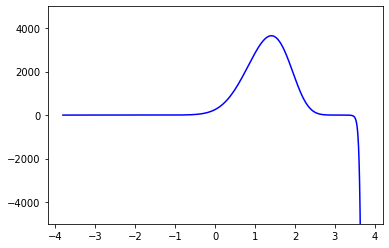

In [16]:
# Plotting
plt.plot(z, WKB_1, "b")
plt.ylim(-5000, 5000)

In [17]:
# Eigenvalue guess range
upper_eigenvalue = 0.3
lower_eigenvalue = 0.1

# Applies WKB approximation to find initial conditions and integrates numerically
WKB_solution = eigenfunction_finder_WKB()
WKB_solution.beta = 0.5
scipy_brent_2, results_brent_2 = optimize.brentq(WKB_solution.eigenfunction, lower_eigenvalue, upper_eigenvalue, full_output=True, xtol=tolerance)
WKB_2 = WKB_solution.eigenfunction_full(scipy_brent_2)
z = WKB_solution.z

In [18]:
print(results_brent_2)

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 0.20986931489529734


(-400, 400)

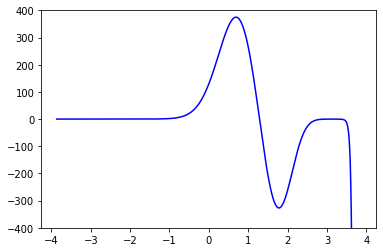

In [19]:
# Plotting
plt.plot(z, WKB_2, "b")
plt.ylim(-400, 400)

In [20]:
# Eigenvalue guess range
upper_eigenvalue = 0.4
lower_eigenvalue = 0.21

# Applies WKB approximation to find initial conditions and integrates numerically
WKB_solution = eigenfunction_finder_WKB()
WKB_solution.beta = 0.5
scipy_brent_3, results_brent_3 = optimize.brentq(WKB_solution.eigenfunction, lower_eigenvalue, upper_eigenvalue, full_output=True, xtol=tolerance)
WKB_3 = WKB_solution.eigenfunction_full(scipy_brent_3)
z = WKB_solution.z

In [21]:
print(results_brent_3)

      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 0.373229248595327


(-20, 20)

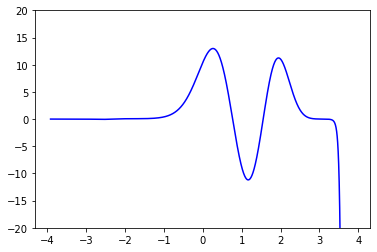

In [22]:
# Plotting
plt.plot(z, WKB_3, "b")
plt.ylim(-20, 20)

In [23]:
# Eigenvalue guess range
upper_eigenvalue = 0.5
lower_eigenvalue = 0.38

# Applies WKB approximation to find initial conditions and integrates numerically
WKB_solution = eigenfunction_finder_WKB()
WKB_solution.beta = 0.5
scipy_brent_4, results_brent_4 = optimize.brentq(WKB_solution.eigenfunction, lower_eigenvalue, upper_eigenvalue, full_output=True, xtol=tolerance)
WKB_4 = WKB_solution.eigenfunction_full(scipy_brent_4)
z = WKB_solution.z

In [24]:
print(results_brent_4)

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 0.44236946536356353


(-0.1, 0.1)

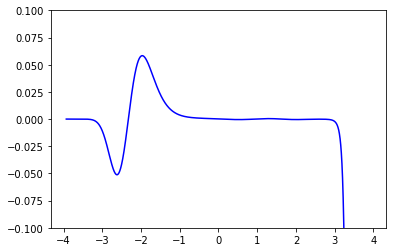

In [25]:
# Plotting
plt.plot(z, WKB_4, "b")
plt.ylim(-0.1, 0.1)